In [1]:
#获取数据集，GAN生成的z,G(z)得到图片，输入DNN_model，使用钩子函数定位最后一个卷积层的输出，插值得到和原来图片一样尺寸的mask,看一下长啥样
# CAM和gradCAM
# https://github.com/frgfm/torch-cam,一个方法库
import model_files as model_all
import torch
import time
import sys
import python_files.my_tools as my_tools
from torchcam.methods import SmoothGradCAMpp,GradCAMpp,SSCAM,CAM,GradCAM
from python_files.my_tools import get_zs_idw_not_class, get_foreground_by_cam

data={
    "model_id":"M1",
    "model_name":"ResNet20",
    "dataset_type":"CIFAR10",
}
# data={
#     "model_id":"M2",
#     "model_name":"AlexNet",
#     "dataset_type":"CIFAR10",
#
# }
device_id = 0
device = torch.device("cuda:" + str(device_id))
model_id =data["model_id"]
model_name = data["model_name"]
print("model_id: ", model_id)
print("model_name: ", model_name)

#申明使用的是全局


model_id:  M1
model_name:  ResNet20


In [2]:
dataset_type = data["dataset_type"]

# CIFAR10生成模型

checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=392000.pth" #kjl测试#############
global G
print("数据类型为：", dataset_type)
G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()

# 提前加载预处理的数据（降维后的2维坐标和对应的高维向量）
# tree_2D_path="./static/data/CIFAR10/2D_kdTree/2D_kdTree_200000.pt"
# data_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_200000.pt"

# tree_2D = torch.load(tree_2D_path)
# dict_zs = torch.load(data_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错


# kjl测试superviced-cnn-ae####################################start
tree_2D_path = "./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000_png_2023-08-30.pt"
data_z_path = "./static/data/CIFAR10/latent_z/BigGAN_random_png_208z_50000_2023-08-30.pt"
tree_2D = torch.load(tree_2D_path)
dict_zs = torch.load(data_z_path, map_location="cpu")
#因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错

Global_DNN_model_dict = {}
Global_rob_predictor_dict = {}
# 分类模型（初始模型为resNet20）
Global_DNN_model_dict[model_id] = model_all.get_DNN_model(dataset_type, model_name)

print("准备分类模型。。。")
Global_DNN_model_dict[model_id].load_state_dict(torch.load("./model_files/" + dataset_type + "/checkpoints/classify_model/" + model_name + ".pt", map_location=device))

Global_DNN_model_dict[model_id].eval()
Global_DNN_model_dict[model_id].to(device)


print("DNN模型准备完毕，准备鲁棒性预测模型。。。")




Global_rob_predictor_dict[model_id] = model_all.get_rob_predictor(dataset_type, model_name)
Global_rob_predictor_dict[model_id].load_state_dict((torch.load("./model_files/"+ dataset_type + "/checkpoints/rob_predictor/kjl_rob_predictor_" + model_name + ".pt", map_location=device))) #自动驾驶使用的8度鲁棒性
Global_rob_predictor_dict[model_id].eval()
Global_rob_predictor_dict[model_id].to(device)
Rob_predictor = Global_rob_predictor_dict[model_id]


# DNN_model = Global_DNN_model_dict["M2"]
print("准备CAM对象。。。")
# 初始化 SmoothGradCAMpp 对象
DNN_model = Global_DNN_model_dict[model_id]
# 原始CAM是最快的，但是不适用于卷积后边接了多个fc的，也就是CAM只适用于MobileNet，ResNet系列，不适用AlexNet和VGG系列
# CAMmethod = CAM(DNN_model)

CAMmethod = CAM(DNN_model)
# CAMmethod = SmoothGradCAMpp(DNN_model)
print("CAM准备完毕。。。")


数据类型为： CIFAR10
准备分类模型。。。
DNN模型准备完毕，准备鲁棒性预测模型。。。
准备CAM对象。。。


CAM准备完毕。。。


In [ ]:
# 获得背景图


In [ ]:
# 新方法,使用confidence

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.utils as utils
# 用来处理zs的类，方便使用batchsize
class Mydata_sets(Dataset):

    def __init__(self, zs):
        super(Mydata_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)
# 定义中间变量字典
activation = {}
# 用来获取模型中间层输出的hook
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_information_mix_conf(coordinates, tree_2D, dict_zs, G, DNN_model,  dataset_type, idw_p = 50,mask_threshold = 0.3):
    # 根据k个最近邻坐标，计算出坐标对应的z
    print("取z中.....")
    time3 = time.time()

    zs = get_zs_idw_not_class(coordinates, tree_2D, dict_zs, p=idw_p)

    zs_datasets = Mydata_sets(zs)
    # 前向传播每次只能一张图
    zs_loader = DataLoader(zs_datasets, batch_size=1, shuffle=False, num_workers=0)  # 指定读取配置信息
    time4 = time.time()
    print("取z消耗时间：", time4-time3)
    sys.stdout.flush()
    print("zs.shape:",zs.shape)

    first = 0 # 判断是否第一次进入循环
    print("生成图片中.....")
    sys.stdout.flush()
    time5 = time.time()
    with torch.no_grad(): # 取消梯度计算，加快运行速度
        for batch_z in zs_loader:
            # z = torch.tensor(batch_z, dtype=torch.float32, device=device).detach()
            z = torch.tensor(batch_z).to(torch.float32).to(device).detach()    # latent code
            if dataset_type == "CIFAR10":
                imgs, layers,max_value, label, cams, binary_cam, fore_imgs, fore_layers,fore_max_value, fore_label = get_foreground_by_cam(z, G, DNN_model, CAMmethod, mask_threshold)
                # imgs = G(z)
                # # DNN_model.layer3.register_forward_hook(get_activation('layer3'))
                # layers = DNN_model(imgs) #分类模型分类图片
                # # CAMlayer = activation['layer3']
                # label = torch.argmax(layers, dim=1)

            elif dataset_type == "SteeringAngle":
                imgs = G(z[:, :256], z[:, 256:])
                # 注册钩子函数到第二层
                DNN_model.pool1.register_forward_hook(get_activation('pool1'))
                label = DNN_model(imgs)
                layers = activation['pool1']
                # cam= layers
                layers = layers.view(layers.size(0), -1)

            if first == 0:
                # robustness = Rob_predictor(layers) #鲁棒性预测网络预测图片
                # fore_robustness = Rob_predictor(fore_layers)
                confidence_imgs = max_value
                confidence_fore_imgs = fore_max_value
                all_imgs = imgs
                all_fore_imgs = fore_imgs
                labels = label
                fore_labels = fore_label
                CAMlayers = cams
                binary_cams = binary_cam
                first = 1
            else:
                # robustness = torch.cat((robustness, Rob_predictor(layers)), dim=0)
                # fore_robustness= torch.cat((fore_robustness, Rob_predictor(fore_layers)), dim=0)
                confidence_imgs = torch.cat((confidence_imgs,max_value),dim=0)
                confidence_fore_imgs = torch.cat((confidence_fore_imgs,fore_max_value),dim=0)
                all_imgs = torch.cat((all_imgs, imgs), dim=0)
                all_fore_imgs = torch.cat((all_fore_imgs, fore_imgs), dim=0)
                labels = torch.cat((labels, label), dim=0)
                fore_labels = torch.cat((fore_labels, fore_label), dim=0)
                CAMlayers = torch.cat((CAMlayers, cams), dim=0)
                binary_cams = torch.cat((binary_cams, binary_cam), dim=0)
        # print("robustness.shape: ", robustness.shape)
        # print("fore_robustness.shape: ", fore_robustness.shape)
        confidence_imgs = confidence_imgs.unsqueeze(1)
        confidence_fore_imgs = confidence_fore_imgs.unsqueeze(1)
        print("confidence_imgs.shape: ", confidence_imgs.shape)
        print("confidence_fore_imgs.shape: ", confidence_fore_imgs.shape)
        print("all_imgs.shape: ", all_imgs.shape)
        print("all_fore_imgs.shape: ", all_fore_imgs.shape)
        print("labels.shape: ", labels.shape)
        print("fore_labels.shape: ", fore_labels.shape)
        print("CAMlayers.shape: ", CAMlayers.shape)
        print("binary_cams.shape: ", binary_cams.shape)

        sys.stdout.flush()

    time6 = time.time()
    print("生成图片消耗时间：", time6-time5)
    sys.stdout.flush()

    # -------------------
    # 从总体1600图片中取400张图片，及其类别信息、二维坐标
    img_labels_lst_400 = []
    img_coords_lst_400 = []
    foreimg_labels_lst_400 = []
    zs_lst_400 = [] #测试用，保存生成的向量
    image_num_in_row = len(confidence_imgs) ** 0.5 # 每行图片为开根号的值40
    # # 保存生成模型的生成图片，不进行归一化
    all_generate_imgs_tensor = all_imgs
    all_generate_foreimgs_tensor = all_fore_imgs
    #  # [0,1] 归一化图片的范围到0~1区间
    all_imgs = ((all_imgs+1)/2).clamp(0.0, 1.0)
    all_fore_imgs = ((all_fore_imgs+1)/2).clamp(0.0, 1.0)

    save_generate_imgs_tensor=[]
    save_generate_imgs_fore_tensor=[]
    # sava_CAMLayer_tensor = []
    for i in range(20):
        for j in range(20):
            # 确定400张在总样本中的位置
            index = int(image_num_in_row * (image_num_in_row / 20 * i) + 1 * (image_num_in_row / 20 * j))

            # 原始图片/前景图片存储，用来方格展示图片，所以用归一化处理之后的
            img_single = all_imgs[index]
            utils.save_image(img_single.detach().cpu(), f'./static/data/' + dataset_type + f'/pic/grid_images/grid_image_{20 * i + j}.png')

            foreimg_single = all_fore_imgs[index]
            utils.save_image(foreimg_single.detach().cpu(), f'./static/data/' + dataset_type + f'/pic/grid_fore_images/grid_fore_image_{20 * i + j}.png')

            save_generate_imgs_tensor.append(all_generate_imgs_tensor[index])

            # 未归一化的进行存储，后边用来辅助单个图片的相关信息
            save_generate_imgs_tensor.append(all_generate_imgs_tensor[index])
            save_generate_imgs_fore_tensor.append(all_generate_foreimgs_tensor[index])

            # 存储坐标，原始图片及前景图片的label
            img_labels_lst_400.append((labels[index]).detach().cpu())
            img_coords_lst_400.append((coordinates[index]))
            foreimg_labels_lst_400.append((fore_labels[index]).detach().cpu())
            # 生成这些图片的z
            zs_lst_400.append(zs[index])

    # save_generate_imgs_tensor = torch.stack(save_generate_imgs_tensor, dim=0)
    # print("save_generate_imgs_tensor.shape",save_generate_imgs_tensor.shape)
    # print("save_generate_imgs_fore_tensor.shape",save_generate_imgs_fore_tensor.shape)
    torch.save(save_generate_imgs_tensor,
               './static/data/' + dataset_type + '/pic/grid_images_tensor/save_generate_imgs_tensor.pt')
    torch.save(save_generate_imgs_fore_tensor,
               './static/data/' + dataset_type + '/pic/grid_fore_images_tensor/save_generate_fore_imgs_tensor.pt')


    torch.save(zs_lst_400, "./临时垃圾-随时可删/向量保存/zs_lst_400.pt")
    return confidence_imgs.detach().cpu().numpy(),confidence_fore_imgs.detach().cpu().numpy(), img_labels_lst_400, foreimg_labels_lst_400, img_coords_lst_400


import numpy as np

coordinates = loaded_data = np.load('./temp/coordinates_test.npy')
print("coordinates_shape", coordinates.shape)

idw_p = 50

# robustness = my_tools.get_robustness_data(coordinates, data_2D, dict_zs, G=G, DNN_model=DNN_model, Rob_predictor=Rob_predictor)
confidence_imgs,confidence_fore_imgs,img_labels_lst_400, foreimg_labels_lst_400, img_coords_lst_400 = get_information_mix_conf(
    coordinates, tree_2D, dict_zs, G=G, DNN_model=DNN_model,dataset_type=dataset_type, idw_p=idw_p, mask_threshold=0.3)

Save generate images tensor shape: torch.Size([400, 3, 32, 32])
tensor([[-2.1566, -4.0102,  0.4962, 17.4092, -1.8070,  2.1662, -0.8258, -2.8742,
         -4.2991, -4.0988]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([17.4092], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')
torch.Size([1, 1, 32, 32])


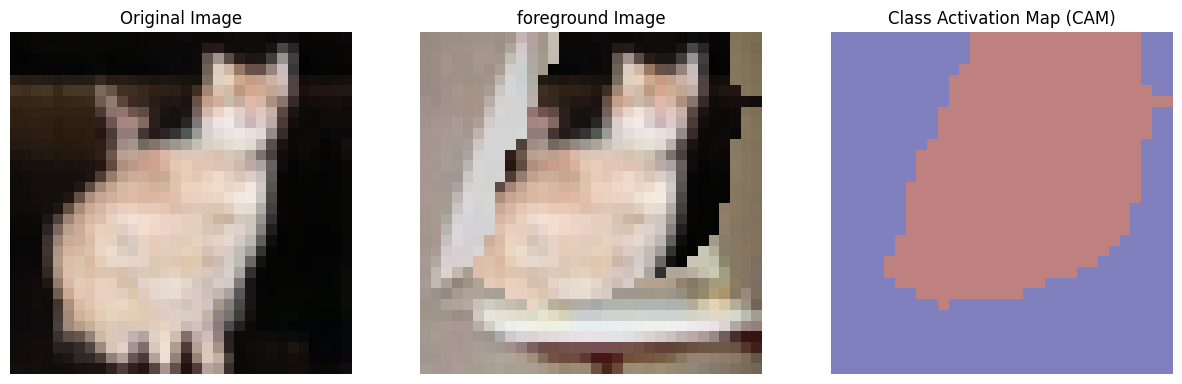

tensor([[-2.3314, -4.8245,  6.3593,  6.0273,  2.8722,  3.6884, -0.8743, -3.2394,
         -3.8367, -3.8413]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([6.3593], device='cuda:0', grad_fn=<MaxBackward0>) tensor([2], device='cuda:0')
torch.Size([1, 1, 32, 32])


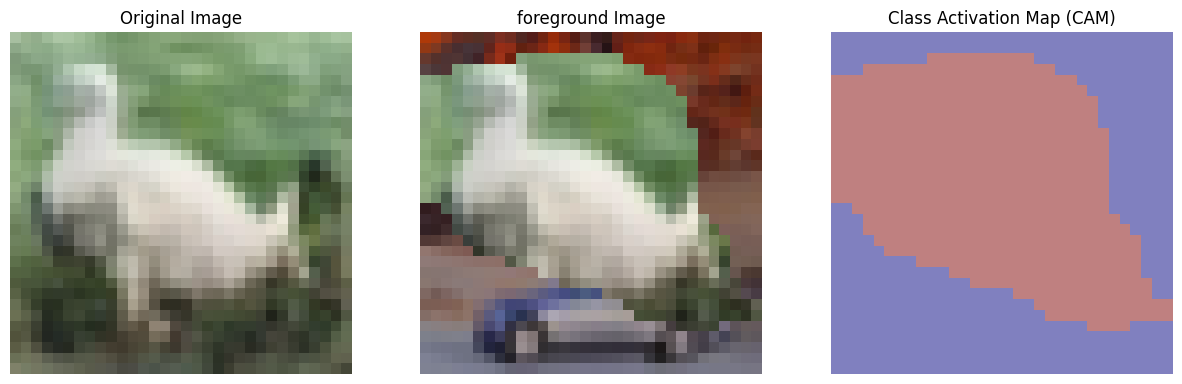

tensor([[ 0.3002, -3.2803, -0.1868,  5.0988, -2.8099,  8.1752,  0.2710, -1.2972,
         -3.6251, -2.6462]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([8.1752], device='cuda:0', grad_fn=<MaxBackward0>) tensor([5], device='cuda:0')
torch.Size([1, 1, 32, 32])


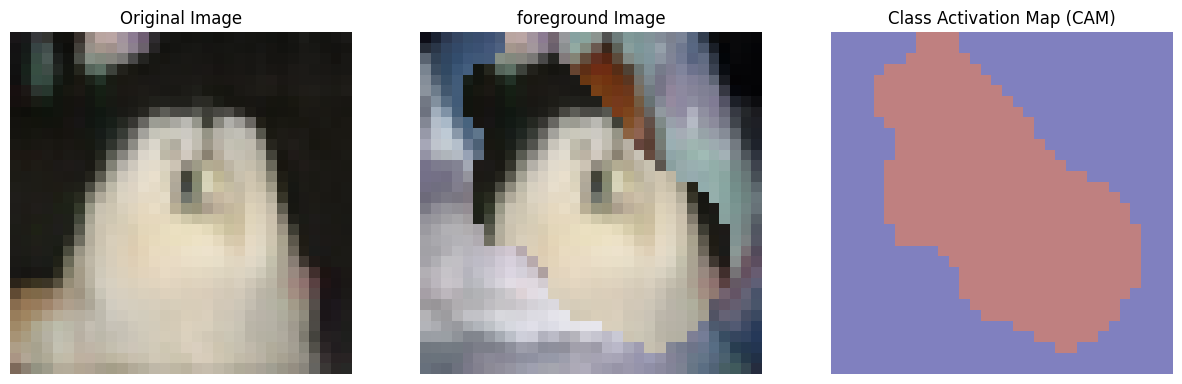

tensor([[-3.2954, -1.6774, -2.3988,  9.9400, -0.3009,  6.2420,  0.1032, -1.1899,
         -3.5814, -3.8415]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([9.9400], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')
torch.Size([1, 1, 32, 32])


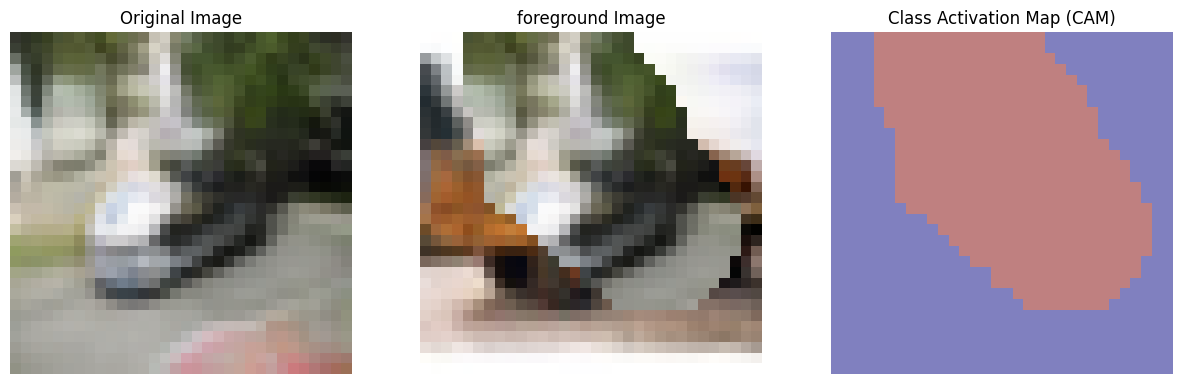

tensor([[ 2.6825, -3.4892, -1.5099,  8.2144, -3.4153,  6.0849, -1.9338, -1.7709,
         -3.3705, -1.4923]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([8.2144], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')
torch.Size([1, 1, 32, 32])


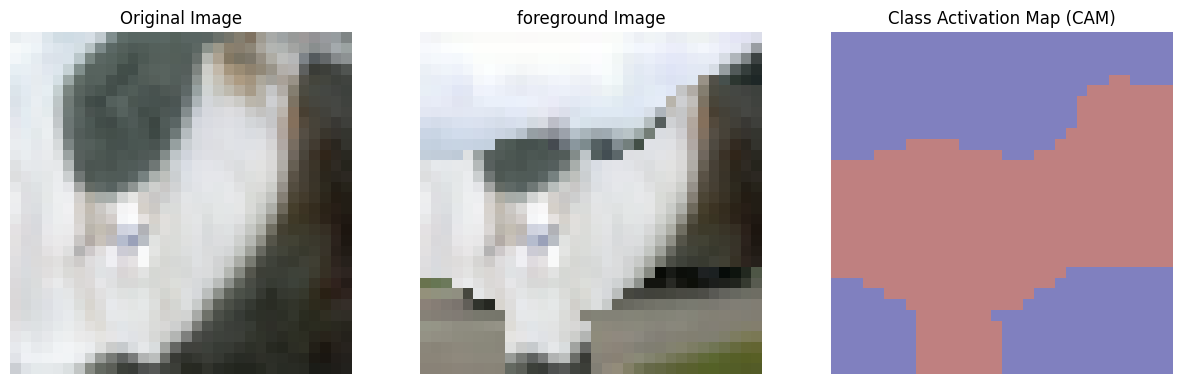

tensor([[-2.1270, -3.7724,  2.5469,  6.1243,  1.0881,  2.5968, -1.8904, -0.9071,
         -1.0729, -2.5866]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([6.1243], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')
torch.Size([1, 1, 32, 32])


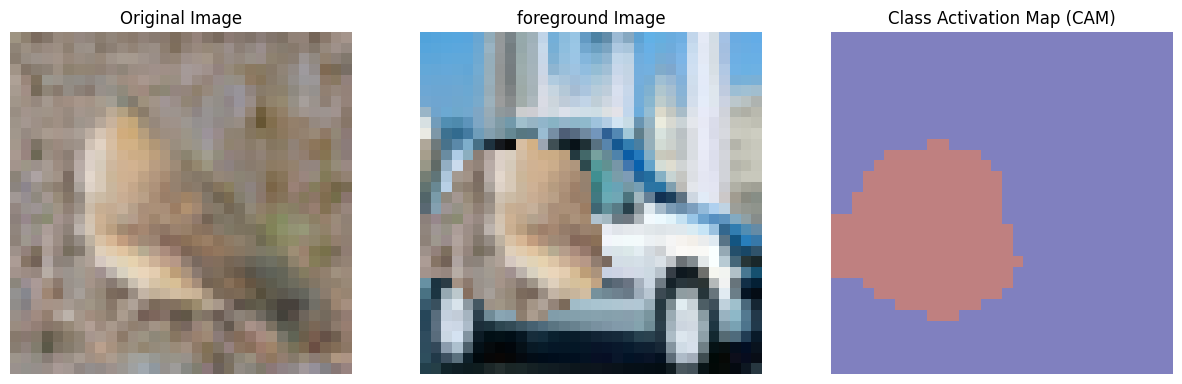

tensor([[-1.3987, -1.6996, -2.1906,  2.7019, -2.0934, 13.3016, -1.9978, -1.1164,
         -2.3656, -3.1418]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([13.3016], device='cuda:0', grad_fn=<MaxBackward0>) tensor([5], device='cuda:0')
torch.Size([1, 1, 32, 32])


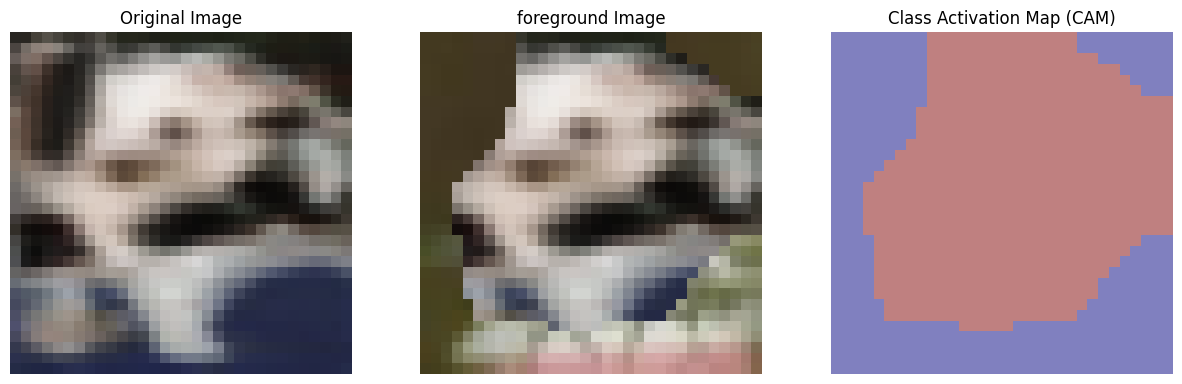

tensor([[-1.4992, -2.1852,  0.5175,  8.6664, -1.1674,  0.7192, -1.6211, -1.7038,
         -1.7168, -0.0099]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([8.6664], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')
torch.Size([1, 1, 32, 32])


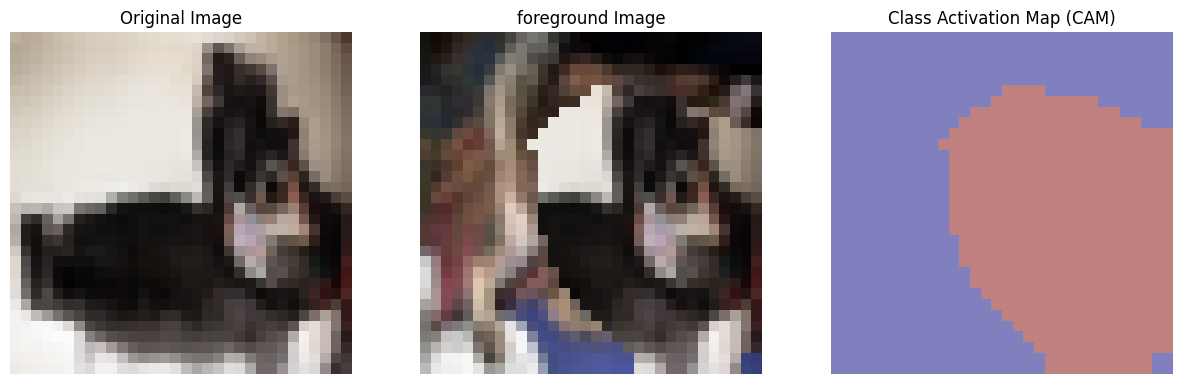

tensor([[-3.4511, -2.9910,  4.8377,  3.8695,  2.1943,  1.2276,  1.9422, -1.7418,
         -2.2658, -3.6219]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([4.8377], device='cuda:0', grad_fn=<MaxBackward0>) tensor([2], device='cuda:0')
torch.Size([1, 1, 32, 32])


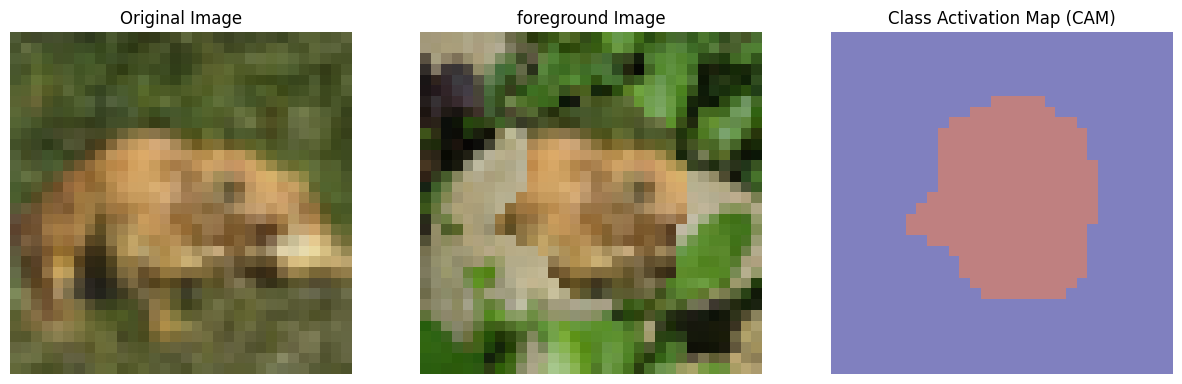

tensor([[ 0.9176, -2.4441,  1.2267,  4.1868, -3.0497,  0.8744,  2.1242, -2.0737,
          1.1832, -2.9456]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([4.1868], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')
torch.Size([1, 1, 32, 32])


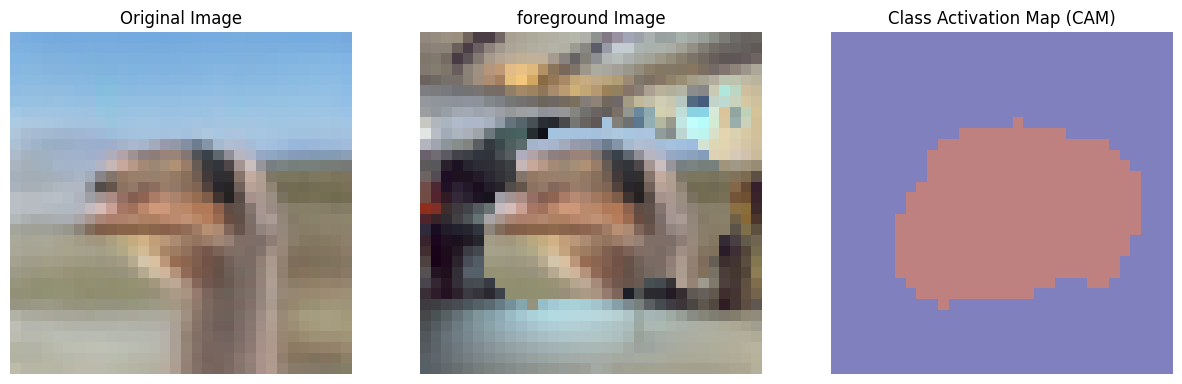

In [11]:
#官方的CAM，自动调取最后一层卷积
from torchvision.transforms import ToPILImage, Normalize
from matplotlib import pyplot as plt
import torch
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
import os
import random
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np

save_generate_imgs_tensor = torch.load(f'./temp/pic/save_generate_imgs_tensor.pt')
# 图片归一化
# save_generate_imgs_tensor = ((save_generate_imgs_tensor+1)/2).clamp(0.0, 1.0)
print("Save generate images tensor shape:", save_generate_imgs_tensor.shape)

activation = {}
# 用来获取模型中间层输出的hook
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for i in range(100,200,10):
    img_tensor = save_generate_imgs_tensor[i]
    # transform = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # image = transform(img_tensor)
    image = img_tensor
    # 添加批次维度并调整形状
    image = image.unsqueeze(0)

    # 执行前向传播以获取卷积层特征(1,10)
    # DNN_model.features.register_forward_hook(get_activation('features'))

    conv_features = DNN_model(image)
    print(conv_features)
    # max_pro_id = conv_features.squeeze(0).argmax().item()
    max_value, max_pro_id = torch.max(conv_features, dim=1)
    print(max_value,max_pro_id)

    # cam = activation['features']

  # # 解释图像并获取 CAM
    cam = CAMmethod(max_pro_id.item(), conv_features)

    cam = torch.nn.functional.interpolate(cam[0].unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
    print(cam.shape)
    # cam = cam.detach().cpu().numpy()  # 将张量转换为 numpy 数组
    cam_min = torch.min(cam)
    cam_max = torch.max(cam)

    # 对CAM张量进行归一化处理
    cam = (cam - cam_min) / (cam_max - cam_min)

    cam = (cam >= 0.4).to(dtype=torch.float32)
    # 在 binary_cams 上添加额外的维度以匹配 imgs 的通道数，并复制到三个通道
    expanded_binary_cams = cam.repeat(1, 3, 1, 1)
    # expanded_binary_cams.to(device = device)
    # 使用 torch.where() 函数将不包含 CAM 的部分设置为空白
    # 将 binary_cams 中值为 0 的位置的像素设置为 0，其余位置保持不变
    masked_imgs = torch.where(expanded_binary_cams == 0, torch.tensor(0,device=device), image)
    # 分开展示
    # 显示原始图像

    # Step 1: 从文件夹中随机选择一张图片
    random_image_number = random.randint(0, 49999)  # 假设图片编号从0到49999
    random_image_filename = './static/data/' + dataset_type + f'/pic/origin_50k_png/pic_{random_image_number}.png'
    random_image = Image.open(random_image_filename)
    random_image_tensor = TF.to_tensor(random_image).unsqueeze(0).to(device)
    # print(random_image_tensor.device,expanded_binary_cams.device,image.device)
    image = ((image+1)/2).clamp(0.0, 1.0)
    masked_random_image_tensor = random_image_tensor * (1 - expanded_binary_cams) + image * expanded_binary_cams


    # image = ((image+1)/2).clamp(0.0, 1.0)
    # masked_imgs = ((masked_imgs+1)/2).clamp(0.0, 1.0)
    # masked_random_image_tensor = ((masked_random_image_tensor+1)/2).clamp(0.0, 1.0)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(image.squeeze(0)))
    plt.axis('off')
    plt.title('Original Image')
    # plt.show()

    plt.subplot(1, 3, 2)
    plt.imshow(to_pil_image(masked_random_image_tensor.squeeze(0)))
    plt.axis('off')
    plt.title('foreground Image')
    # plt.show()

    # 显示 CAM
    plt.subplot(1, 3, 3)
    plt.imshow(cam[0].squeeze(0).cpu().numpy(), cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Class Activation Map (CAM)')
    plt.show()